# Residual Networks

In [257]:
import numpy as np
import h5py

import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

# 1 - The problem of very deep neural networks

随着深度越深，vanishing gradients 梯度消失的情况约明显。

* The main benefit of a very deep network is that it can represent very complex functions. It can also learn features at many different levels of abstraction, from edges (at the shallower layers, closer to the input) to very complex features (at the deeper layers, closer to the output). 

* However, using a deeper network doesn't always help. A huge barrier to training them is vanishing gradients: very deep networks often have a gradient signal that goes to zero quickly, thus making gradient descent prohibitively slow. 

* More specifically, during gradient descent, as you backprop from the final layer back to the first layer, you are multiplying by the weight matrix on each step, and thus the gradient can decrease exponentially quickly to zero (or, in rare cases, grow exponentially quickly and "explode" to take very large values).  


# 2 - Building a Residual Network
$Z1 -> Relu(Z1) -> Maxpool(A1) -> Conv(A1) -> Z2 -> Relu(A1 + Z2) -> ...$

## 2.1 - Initializing data

In [267]:
def load_data ():
    train_dataset = h5py.File('data/train_signs.h5', "r")
    train_X = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_Y = np.array(train_dataset["train_set_y"][:]) # your train set labels
    
    classes = np.array(train_dataset["list_classes"][:]) # the list of classes
    return train_X, train_Y, classes
    
(train_X, train_Y, classes) = load_data()

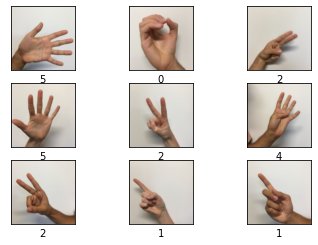

In [268]:
def show_img ():
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        
        plt.imshow(train_X[i], cmap = plt.cm.binary)
        plt.xlabel(train_Y[i])
show_img()

In [269]:
# Normailize image data
train_X_norm = train_X / 255.0

print(train_X_norm.shape) # (1080, 64, 64, 3)
print(train_Y.shape) # (1080,)

(1080, 64, 64, 3)
(1080,)


## 2.2 - Identity block

Identity block = 残差模块

![image](https://wx3.sinaimg.cn/mw1024/701c57e5ly1ge9afo75lij21eu0eqjue.jpg)


**这里我们用3个深度块儿为一组计算**
1. $X => Conv2d => BN => RELU => A1$
2. $A1 => Conv2d => BN => RELU => A2$
3. $A2 => Conv2d => BN => RELU(Z2 + X) => A3$

In [270]:
def identity_block (X, f, filters_num, stage):
    """
    X_shape = (m, n_H, n_W, n_C)
    filters_num = { f1, f2, f3 } in each layer for output name
    key = key in ResNet
    """
    # 创建Tensor
    # Tensor("input_1:0", shape=(?, 4, 4, 6), dtype=float32)
    # X = Input(shape = X_shape) # (n_H_prev * n_H_prev * n_C_prev)
    
    # define name of block
    conv_name_base = 'CONV' + str(stage)
    bn_name_base = 'BN' + str(stage)
    
    # filters_num
    n_C_1, n_C_2, n_C_3 = filters_num
    
    # ========= Layer 1 =========
    # 1. CONV (f * f * n_C_prev * f1)
    # Z = Conv2D(32, (7, 7), strides = (1, 1), padding = 'valid', name = 'CONV0')(X)
    # Tensor("CONV12a_4/BiasAdd:0", shape=(?, 4, 4, 2), dtype=float32)
    Z1_conv = Conv2D(
        n_C_1, 
        (1, 1), 
        padding = 'valid', 
        kernel_initializer = glorot_uniform(seed=0), 
        name = conv_name_base + '2a'
    )(X)
    
    # 2. BN
    # Tensor("BN12a/cond/Merge:0", shape=(?, 4, 4, 2), dtype=float32)
    Z1_bn = BatchNormalization(
        axis = 3, 
        name = bn_name_base + '2a'
    )(Z1_conv)
    
    # 3. RELU
    A1 = Activation('relu')(Z1_bn)
    
    # ========= Layer 2 =========
    # 1. CONV (f * f * n_C_prev * f2)
    # Tensor("CONV12b/BiasAdd:0", shape=(?, 4, 4, 4), dtype=float32)
    Z2_conv = Conv2D(
        filters = n_C_2, 
        kernel_size = (f, f), 
        padding = 'same', 
        kernel_initializer=glorot_uniform(seed=0), # Xavier统一初始化器
        name = conv_name_base + '2b'
    )(A1)
    
    # 2. BN
    Z2_bn = BatchNormalization(
        axis = 3, 
        name = bn_name_base + '2b'
    )(Z2_conv)
    
    # 3. RELU
    A2 = Activation('relu')(Z2_bn)
    
    # ========= Layer 3 =========
    # 1. CONV (f * f * n_C_prev * f3)
    # Tensor("CONV12c_1/BiasAdd:0", shape=(?, 4, 4, 6), dtype=float32)
    Z3_conv = Conv2D(
        filters = n_C_3, 
        kernel_size = (1, 1), 
        padding = 'valid', 
        kernel_initializer=glorot_uniform(seed=0), # Xavier统一初始化器
        name = conv_name_base + '2c'
    )(A2)
    
    # 2. BN
    Z3_bn = BatchNormalization(
        axis = 3, 
        name = bn_name_base + '2c'
    )(Z3_conv)
    
    # 3. RELU  Z3_bn 和 X 尺寸一样
    # https://github.com/farizrahman4u/recurrentshop/issues/87 
    # Z3 = Z3_bn + X 这么写会报错
    Z3 = Add()([Z3_bn, X])
    A3 = Activation('relu')(Z3)

    return A3

In [271]:
# np.random.seed(1)
# X = np.random.randn(3, 4, 4, 6) # m = 3, n_W, n_H = 4, n_C = 6

# X_shape = X.shape[1:]
# A3 = identity_block(X_shape, f = 2, filters_num = [2, 4, 6], stage = 1)
# # Tensor("activation_16/Relu:0", shape=(?, 4, 4, 6), dtype=float32)

# print(A3) 

## 2.3 - The convolutional block


![image](https://github.com/Kulbear/deep-learning-coursera/raw/997fdb2e2db67acd45d29ae418212463a54be06d/Convolutional%20Neural%20Networks/images/convblock_kiank.png)

#2.2 处理
>1. $X => Conv2d => BN => RELU => A1$
>2. $A1 => Conv2d => BN => RELU => A2$
>3. $A2 => Conv2d => BN => RELU(Z2 + X) => A3$

这里我们需要特殊处理3:
- ZZ = Z2 + BN_3(CONV2d_3(X))
- X => CONV2d_3: 1 * 1 * n_C_3, stride = (1,1), valid padding
3. $A2 => Conv2d => BN => RELU(ZZ) => A3$


In [272]:
def convolutional_block (X, f, filters_num, stage, s = 2):
    """
    X_shape: for compute shape of X (n_H, n_W, n_C)
    f: filter => f * f
    filters_num: n_C_1, n_C_2, n_C_3
    key: key in ResNet
    s: stride
    """
    # 用来初始化一个keras tensor的，tensor说白了就是个数组
    # Tensor("input_9:0", shape=(?, 4, 4, 6), dtype=float32)
    # X = Input(shape = X_shape)
    
    # defining name basis
    conv_name_base = 'CONV' + str(stage)
    bn_name_base = 'BN' + str(stage)
    
    # 每一层输出的 n_C
    n_C_1, n_C_2, n_C_3 = filters_num
    
    # ======== Layer 1 ========
    Z1_conv = Conv2D(
        n_C_1, 
        kernel_size = (1, 1), 
        strides = (s, s), 
        padding = 'valid',
        kernel_initializer = glorot_uniform(seed=0),
        name = conv_name_base + '2a'
    )(X)
    Z1_bn = BatchNormalization(axis = 3, name = bn_name_base + '2a')(Z1_conv)
    A1 = Activation('relu')(Z1_bn)
    
    # ======== Layer 2 ========
    Z2_conv = Conv2D(
        n_C_2,
        kernel_size = (f, f), 
        strides = (1, 1), 
        padding = 'same',
        kernel_initializer = glorot_uniform(seed=0),
        name = conv_name_base + '2b'
    )(A1)
    Z2_bn = BatchNormalization(axis = 3, name = bn_name_base + '2b')(Z2_conv)
    A2 = Activation('relu')(Z2_bn)
    
    # ======== Layer 3 ========
    Z3_conv = Conv2D(
        n_C_3,
        kernel_size = (1, 1), 
        strides = (1, 1), 
        padding = 'valid',
        kernel_initializer = glorot_uniform(seed=0),
        name = conv_name_base + '2c'
    )(A2)
    Z3_bn = BatchNormalization(axis = 3, name = bn_name_base + '2c')(Z3_conv)
    
    X_conv_3 = Conv2D(
        n_C_3,
        kernel_size = (1, 1), 
        strides = (s, s), 
        padding = 'valid',
        kernel_initializer = glorot_uniform(seed=0),
        name = stage + 'X_conv_3'
    )(X)
    X_bn_3 = BatchNormalization(axis = 3, name = stage + 'X_bn_3')(X_conv_3)
    # https://github.com/farizrahman4u/recurrentshop/issues/87 
    # Z3_bn + X_bn_3 这么写会报错
    A_PLUS = Add()([Z3_bn, X_bn_3])
    A3 = Activation('relu')(A_PLUS)
    
    return A3
    

In [273]:
# np.random.seed(1)
# X = np.random.randn(3, 4, 4, 6) # m = 3, n_W, n_H = 4, n_C = 6

# X_shape = X.shape[1:]
# A3 = convolutional_block(X_shape, f = 2, filters_num = [2, 4, 6], stage = 2, s = 2)

# # Tensor("activation_21/Relu:0", shape=(?, 2, 2, 6), dtype=float32)
# print(A3)

# 3 - Building your first ResNet model (50 layers)

![image](https://github.com/Kulbear/deep-learning-coursera/raw/997fdb2e2db67acd45d29ae418212463a54be06d/Convolutional%20Neural%20Networks/images/resnet_kiank.png)

- Zero Padding: (3, 3)

- Stage1
    - CONV: f: 7 * 7, n_C: 64, s: 2
    - BN: - 
    - MaxPooling: f = (3,3) s = (2,2)

- Stage2
    - convolutional_block: filters_num = [64, 64, 256], f = 3, s = 1
    - identity_block: filters_num = [64, 64, 256], f = 3
    
- Stage3
    - convolutional_block: filters_num = [128,128,512], f = 3, s = 2
    - identity_block: filters_num = [128,128,512], f = 3

- Stage 4
    - convolutional_block: filters_num = [256, 256, 1024], f = 3, s = 2
    - identity_block: filters_num = [256, 256, 1024], f = 3
    
- Stage 5
    - convolutional_block: filters_num = [512, 512, 2048], f = 3, s = 2
    - identity_block: filters_num = [256, 256, 2048], f = 3
    
- Average pool: f = 2
- Flatten
- FC

```html
identity block: 
is used when there is no change in input and output dimensions
输入输出尺寸一致

convolutional block: 
is almost same as identity block but there is a convolutional layer in short-cut path to just change the dimension such that the dimension of input and output matches
输入输出尺寸不一致
```

In [274]:
def ResNet50 (input_shape = (64, 64, 3), classes = 6):
    """
    input_shape: 图像尺寸
    classes: 输出类别个数
    """
    # 1. create the tensor with input_shape
    X_input = Input(input_shape)
    
    # 2. Zero-padding
    X_pad = ZeroPadding2D((3, 3))(X_input)
    
    # 3. Stage 1
    # CONV => BN => RELU => MAXPOOL
    Z1_conv = Conv2D(64, (7, 7), strides = (2, 2), name = 'Stage1_conv', kernel_initializer=glorot_uniform(seed=0))(X_pad)
    Z1_bn = BatchNormalization(axis = 3, name = 'Stage1_bn')(Z1_conv)
    A1_relu = Activation('relu')(Z1_bn)
    A1 = MaxPooling2D((3, 3), strides = (2, 2))(A1_relu) # f: 3, s: 2
    
    
    # 4. Stage 2
    # CONV_BLOCK (*3) => INDENTITY_BLOCK (3) => INDENTITY_BLOCK (*3)
    s2_num = [64, 64, 256]
    f = 3
    s = 1
    A2_cb = convolutional_block(A1, f, s2_num, stage = 'Stage2_Conv_Block', s = s)
    A2_ib_1 = identity_block (A2_cb, f, s2_num, stage = 'Stage2_Identity_Block_1')
    A2_ib_2 = identity_block (A2_ib_1, f, s2_num, stage = 'Stage2_Identity_Block_2')
    A2 = A2_ib_2
    
    # Tensor("activation_121/Relu:0", shape=(?, 15, 15, 256), dtype=float32)
    print(A2)
    
    # 5. Stage 3
    # CONV_BLOCK (*3) => INDENTITY_BLOCK (*3) => INDENTITY_BLOCK (*3) => INDENTITY_BLOCK (*3)
    s3_num = [128, 128, 512]
    f = 3
    s = 2
    A3_cb = convolutional_block(A2, f, s3_num, 'Stage3_Conv_Block', s = s)
    A3_ib_1 = identity_block (A3_cb, f, s3_num, stage = 'Stage3_Identity_Block_1')
    A3_ib_2 = identity_block (A3_ib_1, f, s3_num, stage = 'Stage3_Identity_Block_2')
    A3_ib_3 = identity_block (A3_ib_2, f, s3_num, stage = 'Stage3_Identity_Block_3')
    A3 = A3_ib_3
    
    # 6. Stage 4
    # CONV_BLOCK (*3) => INDENTITY_BLOCK (*3) => INDENTITY_BLOCK (*3) => INDENTITY_BLOCK (*3) => INDENTITY_BLOCK (*3) => INDENTITY_BLOCK (*3)
    s4_num = [256, 256, 1024]
    f = 3
    s = 2
    A4_cb = convolutional_block(A3, f, s4_num, stage = 'Stage4_Conv_Block', s = s)
    A4_ib_1 = identity_block (A4_cb, f, s4_num, stage = 'Stage4_Identity_Block_1')
    A4_ib_2 = identity_block (A4_ib_1, f, s4_num, stage = 'Stage4_Identity_Block_2')
    A4_ib_3 = identity_block (A4_ib_2, f, s4_num, stage = 'Stage4_Identity_Block_3')
    A4_ib_4 = identity_block (A4_ib_3, f, s4_num, stage = 'Stage4_Identity_Block_4')
    A4_ib_5 = identity_block (A4_ib_4, f, s4_num, stage = 'Stage4_Identity_Block_5')
    
    A4 = A4_ib_5
    
    # 7. Stage 5
    # CONV_BLOCK (*3) => INDENTITY_BLOCK (*3) => INDENTITY_BLOCK (*3)
    s5_num = [512, 512, 2048]
    f = 3
    s = 2
    A5_cb = convolutional_block(A4, f, s5_num, stage = 'Stage5_Conv_Block', s = s)
    s5_num = [256, 256, 2048]
    A5_ib_1 = identity_block (A5_cb, f, s5_num, stage = 'Stage5_Identity_Block_1')
    A5_ib_2 = identity_block (A5_ib_1, f, s5_num, stage = 'Stage5_Identity_Block_2')
    
    A5 = A5_ib_2
    
    # 8. AveragePool
    A6 = AveragePooling2D(pool_size = (2, 2), padding = 'same')(A5)
    
    # 9. Flatten
    A7_flatten = Flatten()(A6)
    
    # 10. FC
    Y_outputs = Dense(
        classes,
        activation = 'softmax',
        name = 'FC_softmax' + str(classes),
        kernel_initializer=glorot_uniform(seed=0)
    )(A7_flatten)
    
    model = keras.models.Model(inputs = X_input, outputs = Y_outputs, name = 'ResNet50')
    
    return model

In [275]:
model = ResNet50(input_shape=(64, 64, 3), classes=6)

Tensor("activation_647/Relu:0", shape=(?, 15, 15, 256), dtype=float32)


In [276]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [277]:
# 需要处理一下y值, 如果有6个类型, 但是返回值是[0], [5], ...., 就需要将index加到对应的位置上
print(train_Y) # [5 0 2 ... 2 4 5]

train_Y_eye = np.eye(6)[train_Y] # 一行为一组数据
print(train_Y_eye.shape) # (1080, 6)

[5 0 2 ... 2 4 5]
(1080, 6)


In [278]:
model.fit(train_X_norm, train_Y_eye, epochs = 2, batch_size = 32)

Epoch 1/2
1080/1080 [==============================] - 48s 45ms/step - loss: 1.8194 - acc: 0.5056
Epoch 2/2
1080/1080 [==============================] - 34s 32ms/step - loss: 0.6260 - acc: 0.7852


In [279]:
test_dataset = h5py.File('data/test_signs.h5', "r")
test_X = np.array(test_dataset["test_set_x"][:])
test_Y = np.array(test_dataset["test_set_y"][:])

test_X_norm = test_X / 255.0
test_Y_eye = np.eye(6)[test_Y] # 一行为一组数据 # (120, 6)

In [280]:
preds = model.evaluate(test_X_norm, test_Y_eye)
print("Loss = " + str(preds[0]))
print("Test Accuracy = " + str(preds[1]))

120/120 [==============================] - 4s 32ms/step
Loss = 0.31570845444997153
Test Accuracy = 0.875000003973643


# 4. My Own Picture

TODO

In [303]:
# def img (name):
#     img_path = 'data/' + name + '.png'
#     print(img_path)
    
#     # <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x1446DDC90>
#     img = image.load_img(img_path, target_size = (64, 64))
#     imshow(img)

#     # 将图像转为矩阵, (64, 64, 3)
#     img_matrix = image.img_to_array(img)
#     # 代表一个样本 (1, 64, 64, 3)
#     X = np.expand_dims(img_matrix, axis=0)
#     X = preprocess_input(X)
#     return X

# X = img('2')
# output = model.predict(X)
# print('预测结果:', np.argmax(output))

In [304]:
# index = 25
# imshow(train_X[index])
# print(train_Y[index])
# X = np.expand_dims(train_X[index] / 255.0, axis=0)
# output = model.predict(X)

# print('预测结果:', np.argmax(output))

# 5. Summary

In [306]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_23 (ZeroPadding2 (None, 70, 70, 3)    0           input_39[0][0]                   
__________________________________________________________________________________________________
Stage1_conv (Conv2D)            (None, 32, 32, 64)   9472        zero_padding2d_23[0][0]          
__________________________________________________________________________________________________
Stage1_bn (BatchNormalization)  (None, 32, 32, 64)   256         Stage1_conv[0][0]                
__________________________________________________________________________________________________
activation

In [314]:
# plot_model(model, to_file='model.png')
# SVG(model_to_dot(model).create(prog='dot', format='svg'))